# 7. Finetuning of the models

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**



**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from numpy import sqrt
from numpy import argmax

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA


from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file
from metrics import evaluate_model

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set()

---
## Load data and get internal benchmark

In [2]:
df_dataset = pd.read_parquet('data/_6_with_player_stats.parquet')

In [3]:
_, lg = run_logistic_regression(df_dataset, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_dataset, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_dataset, c_matrix=False, r_curve=False);

========== Logistic Regression ==========
Accuracy: 0.5516
F1 Score: 0.4954
AUC-ROC Score: 0.5870
-----------------------------------------
Precision: 0.5687
Recall: 0.4389
========== LightGBM Classifier ==========
Accuracy: 0.6974
F1 Score: 0.7119
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6812
Recall: 0.7455
========= KNeighbors Classifier =========
Accuracy: 0.5609
F1 Score: 0.5696
AUC-ROC Score: 0.5859
-----------------------------------------
Precision: 0.5603
Recall: 0.5793


---
## Experiments with fine tuning
Different techniques will be applied to try to improve the models


---

#### Set training and test data for experiments

In [4]:
target = 'goal'
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(df_dataset[features], df_dataset[target], test_size=0.3, random_state=42)

---

## Optimizing KNeighbors Classifier

--- 
KNC is too slow and too unprecize probably due to increasing number of features. let's reduce.


In [5]:
target = 'goal'
best_col = ''
max_value = -1

for col in ['distance', 'angle', 'goalie_id', 'goals']:
    lst = []
    lst.append(col)
    print(lst)
    _, metrics = run_kneighbors_classifier(df_dataset, features=lst, c_matrix=False, r_curve=False);
    if metrics['accuracy'] > max_value: 
        max_value = metrics['accuracy']
        best_col = col
    
print(f'Best accuracy={max_value} achieved with the features {best_col}')
print('-----------------------------------------')

#evaluate_model(model, X_test, y_test, threshold=best_threshold, c_matrix=True, r_curve=True);    

['distance']
========= KNeighbors Classifier =========
Accuracy: 0.6590
F1 Score: 0.6705
AUC-ROC Score: 0.7039
-----------------------------------------
Precision: 0.6505
Recall: 0.6917
['angle']
========= KNeighbors Classifier =========
Accuracy: 0.6227
F1 Score: 0.6265
AUC-ROC Score: 0.6663
-----------------------------------------
Precision: 0.6221
Recall: 0.6309
['goalie_id']
========= KNeighbors Classifier =========
Accuracy: 0.5090
F1 Score: 0.4910
AUC-ROC Score: 0.5188
-----------------------------------------
Precision: 0.5114
Recall: 0.4722
['goals']
========= KNeighbors Classifier =========
Accuracy: 0.5603
F1 Score: 0.5867
AUC-ROC Score: 0.5833
-----------------------------------------
Precision: 0.5550
Recall: 0.6222
Best accuracy=0.6590083782308405 achieved with the features distance
-----------------------------------------


In [20]:
# saving as best tuned
save_metrics('with_player_stats_tuned', metrics_knc=metrics)

---
#### Best value with KNC achieving using 3 features ['distance', 'angle', 'goalie_id'] only

In [6]:
_, metrics = run_kneighbors_classifier(df_dataset, features=['distance', 'angle', 'goalie_id'], c_matrix=False, r_curve=False);

========= KNeighbors Classifier =========
Accuracy: 0.6793
F1 Score: 0.6933
AUC-ROC Score: 0.7343
-----------------------------------------
Precision: 0.6662
Recall: 0.7226


### Optimizing Logistic Regression

The logistic regression model is performing very pure. High Precision, Low Recall. Accuracy close to the random choice.

---
The target is balanced, shouldn't be a problem:

In [7]:
# what is the portion of the target 1 in the dataset?
df_dataset[df_dataset.goal==1].shape[0] / df_dataset.shape[0]

0.5010324546787998

---
Trying to use scaling of X data

Accuracy: 0.6934
F1 Score: 0.7038
AUC-ROC Score: 0.7526
-----------------------------------------
Precision: 0.6827
Recall: 0.7263


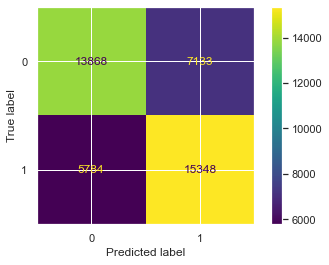

In [8]:
# create model
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train,y_train)
#evaluate
evaluate_model(model, X_test, y_test, c_matrix=True, r_curve=False);

Looks much better now!!!  Scaler helped a lot!

---
Trying to change threshold to make it even better.

Best accuracy=0.6940877696817221 achieved with the threshold 0.4780000000000001
-----------------------------------------
Accuracy: 0.6941
F1 Score: 0.7117
AUC-ROC Score: 0.7526
-----------------------------------------
Precision: 0.6749
Recall: 0.7527


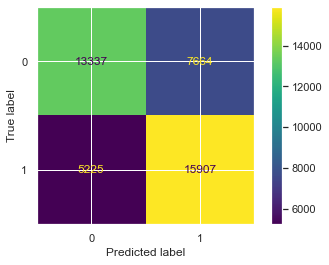

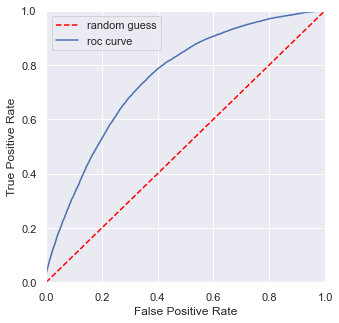

In [9]:
max_value = -1
best_threshold = 0
for thresh in np.arange(0.4, 0.6, 0.001):
    _, metrics = evaluate_model(model, X_test, y_test, threshold=thresh, c_matrix=False, r_curve=False, suppress=True);
    if metrics['accuracy'] > max_value: 
        max_value = metrics['accuracy']
        best_threshold = thresh
    
print(f'Best accuracy={max_value} achieved with the threshold {best_threshold}')
print('-----------------------------------------')

_, lg = evaluate_model(model, X_test, y_test, threshold=best_threshold, c_matrix=True, r_curve=True);

Next improvement using custom threshold. ^^

In [10]:
#saving it
save_metrics('with_player_stats_tuned', metrics_lg=lg)

---
#### Trying just a small subset of features:

Accuracy: 0.6727
F1 Score: 0.6828
AUC-ROC Score: 0.7256
-----------------------------------------
Precision: 0.6643
Recall: 0.7024


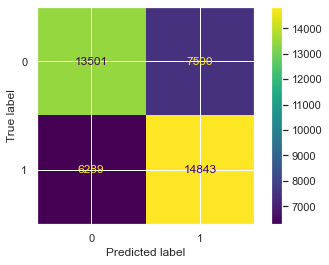

In [11]:
target = 'goal'
features2 = ['distance', 'angle', 'goals']

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_dataset[features2], df_dataset[target], test_size=0.3, random_state=42)

# create model
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train2,y_train2)
#evaluate
evaluate_model(model, X_test2, y_test2, c_matrix=True, r_curve=False);

not really a difference

---

#### How did perform of training data?

In [12]:
# create model
model = make_pipeline(StandardScaler(),
                      LogisticRegression(max_iter=10000));
# fit model
model.fit(X_train,y_train)
#evaluate
evaluate_model(model, X_train, y_train, c_matrix=False, r_curve=False);

Accuracy: 0.6912
F1 Score: 0.7020
AUC-ROC Score: 0.7514
-----------------------------------------
Precision: 0.6794
Recall: 0.7260


Pretty the same metric compared to test data. No indication of over fitting

---
### Optimizing LightGBM

---
LightGBM was performing much better than Logistic Regression at the beginning. Let's try similar steps to see what happens.

#### Using standard scaler for LightGBM

Accuracy: 0.6969
F1 Score: 0.7114
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6808
Recall: 0.7449


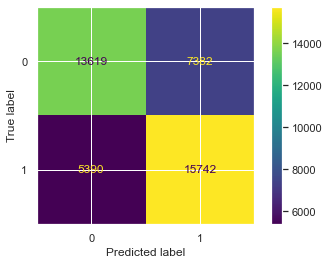

In [13]:
# create model
model = make_pipeline(StandardScaler(), LGBMClassifier(random_state=42));
# fit model
model.fit(X_train,y_train)
# evaluate
evaluate_model(model, X_test, y_test, c_matrix=True, r_curve=False);

This is actually almost the same but scaler made it little worse.

---

In [14]:
target = 'goal'
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(df_dataset[features], df_dataset[target], test_size=0.3, random_state=42)

# create model
model = LGBMClassifier(random_state=42);
# fit model
model.fit(X_train,y_train)

LGBMClassifier(random_state=42)

Best accuracy=0.6976004556998078 achieved with the threshold 0.5020000000000001
-----------------------------------------
Accuracy: 0.6976
F1 Score: 0.7116
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6821
Recall: 0.7438


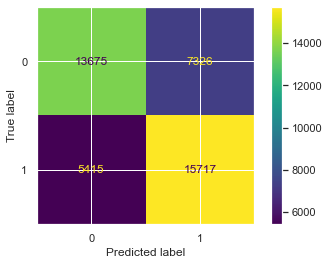

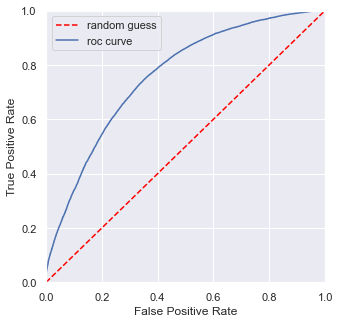

In [15]:
max_value = -1
best_threshold = 0
for thresh in np.arange(0.4, 0.6, 0.001):
    _, metrics = evaluate_model(model, X_test, y_test, threshold=thresh, c_matrix=False, r_curve=False, suppress=True);
    if metrics['accuracy'] > max_value: 
        max_value = metrics['accuracy']
        best_threshold = thresh
    
print(f'Best accuracy={max_value} achieved with the threshold {best_threshold}')
print('-----------------------------------------')

_, lgbm = evaluate_model(model, X_test, y_test, threshold=best_threshold, c_matrix=True, r_curve=True);

This is slightly improvement compared to the benchmark but not too much. Accuracy higher by 0.0002 which is accualy really not too much

In [16]:
#saving it
save_metrics('with_player_stats_tuned', metrics_lgbm=lgbm)

---
#### How would it perform on training data?

In [17]:
# create model
model = LGBMClassifier(random_state=42);
# fit model
model.fit(X_train,y_train)
# evaluate
evaluate_model(model, X_train, y_train, c_matrix=False, r_curve=False);

Accuracy: 0.7073
F1 Score: 0.7214
AUC-ROC Score: 0.7792
-----------------------------------------
Precision: 0.6891
Recall: 0.7569


Very comparable.

---
#### Ad-hoc parameters selection for LGBM and cross-validation

Starting...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'boosting_type': 'gbdt', 'colsample_bytree': 0.85, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 120, 'num_leaves': 24, 'objective': 'binary', 'reg_alpha': 6, 'reg_lambda': 6, 'seed': 600, 'subsample': 0.75}
0.6962231433001976
Training ran in 4020.12991 seconds
Accuracy: 0.6967
F1 Score: 0.7114
AUC-ROC Score: 0.7601
-----------------------------------------
Precision: 0.6803
Recall: 0.7455


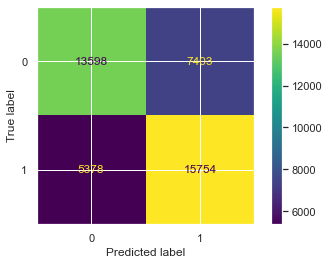

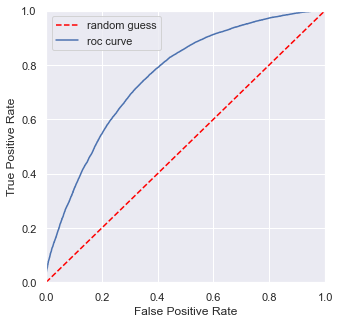

In [18]:
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.75, 0.8, 0.85], 
          'learning_rate': [0.05, 0.1, 0.15], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [80, 100, 120], 
          'num_leaves': [12, 18, 24], 
          'objective': ['binary'], 
          'reg_alpha': [4, 5, 6], 
          'reg_lambda': [4, 5, 6], 
          'seed': [500, 600, 700], 
          'subsample': [0.75]}

model = LGBMClassifier();
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

mod, metrs = evaluate_model(grid, X_test, y_test)

Even if using GridSearchCV, the performance of the model was not increased.

----------------------------------------